In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Downlad Pre-Trained Models

In [ ]:
downloaded = drive.CreateFile({'id':"1yjqwH_-UamZaK33pUMLkaluW34fxIBBT"})
downloaded.GetContentFile('task1_rnn_bert.h5')

In [ ]:
!mkdir -p task1_cnn_bert
!mkdir -p task1_cnn_bert/assets/
!mkdir -p task1_cnn_bert/variables/

In [ ]:
downloaded = drive.CreateFile({'id':"18iZftTT4ViiscU0xy217wedLNdCVG2zI"})
downloaded.GetContentFile('task1_cnn_bert/saved_model.pb')

downloaded = drive.CreateFile({'id':"1N2fsIgoNj6-44jp89lbAfxchVxTxgG33"})
downloaded.GetContentFile('task1_cnn_bert/variables/variables.index')
downloaded = drive.CreateFile({'id':"10LJ34Je-WkhKM4t8ZWQ2ElXyzGBgLxj5"})
downloaded.GetContentFile('task1_cnn_bert/variables/variables.data-00000-of-00001')


# Load Models

In [ ]:
import tensorflow as tf

In [ ]:
text_model1 = tf.keras.models.load_model('task1_rnn_bert.h5')
text_model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1200, 500)         59774000  
_________________________________________________________________
global_average_pooling1d (Gl (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               100200    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1206      
Total params: 59,875,406
Trainable params: 59,875,406
Non-trainable params: 0
_________________________________________________________________


In [ ]:
text_model2 = tf.keras.models.load_model('task1_cnn_bert')
text_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1200, 500)         59774000  
_________________________________________________________________
conv1d (Conv1D)              (None, 1199, 100)         100100    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1197, 100)         30100     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1

# Test Data

In [ ]:
downloaded = drive.CreateFile({'id':"1U4dA8-LTKrnaq85BIoILtnpa2XdD03KA"})
downloaded.GetContentFile('test_new.csv')

In [ ]:
import pandas as pd

test = pd.read_csv('test_new.csv')
test.shape

(4574, 6)

In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 51kB 4.7MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=b3634d4bdc1e92f35557d24c67d28f372bf482d270644bbe06fe0c91a8016a86
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=bb3ee85a2a825b118510ce6c299e9f1957aadd7f49dafb9725215b14834d5787
  Stored in directory: /root/.cache/pip/wheels/d0/4a/70/ff12450229ff1955abf01f365051d4faae1c20aef53ab4cf09
  Created wheel for params-flow: filename=params_flow-0.8.2-cp37-none-any.whl size=19472 sha256=203ff0d71904b3516194d5c606b4857ce002c4ca0031ca240867e75a4c82aa7c
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.2MB 8.0MB/s 


In [ ]:
import bert
import tensorflow_hub as hub

BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1", trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [ ]:
from tensorflow.keras.preprocessing import sequence

def getTokens(df):
  lyrics = df['Lyrics'].values
  X = [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(lyric)) for lyric in lyrics]
  return X

def padSeq(X, max):
  X = sequence.pad_sequences(X, maxlen=max, padding='post')
  return X

In [ ]:
X_test = getTokens(test)
X_test = padSeq(X_test,  1200)
y_test = test['GenreY'].values
X_test.shape, y_test.shape

((4574, 1200), (4574,))

In [ ]:
type(X_test), type(y_test)

(numpy.ndarray, numpy.ndarray)

# Evaluation

In [ ]:
loss = [0.0, 0.0]
accu = [0.0, 0.0]

In [ ]:
loss[0], accu[0] = text_model1.evaluate(X_test, y_test)
print(f'Loss:     {loss[0]}')
print(f'Accuracy: {accu[0]}')

143/143 [==============================] - 5s 30ms/step - loss: 2.1369 - accuracy: 0.4018
Loss:     2.136852502822876
Accuracy: 0.40183645486831665


In [ ]:
y_probability = text_model1.predict(X_test)
y_probability.shape

(4574, 6)

In [ ]:
import numpy as np

y_predict = np.argmax(y_probability, axis=1)
y_predict.shape

(4574,)

In [ ]:
from tensorflow.math import confusion_matrix
import pandas as pd

array = confusion_matrix(y_test, y_predict).numpy()
tnames = ['Indie', 'Folk', 'Jazz', 'Metal', 'Pop', 'Rock']
df_cm = pd.DataFrame(array, tnames, tnames)
df_cm

,Indie,Folk,Jazz,Metal,Pop,Rock
Indie,156,47,32,82,29,113
Folk,74,115,53,82,16,103
Jazz,49,35,287,33,35,142
Metal,51,11,7,604,15,83
Pop,156,47,150,171,215,294
Rock,233,64,119,335,75,461


In [ ]:
from sklearn.metrics import classification_report

tnames = ['Indie', 'Folk', 'Jazz', 'Metal', 'Pop', 'Rock']
print(classification_report(y_test, y_predict, target_names=tnames))

              precision    recall  f1-score   support

       Indie       0.22      0.34      0.26       459
        Folk       0.36      0.26      0.30       443
        Jazz       0.44      0.49      0.47       581
       Metal       0.46      0.78      0.58       771
         Pop       0.56      0.21      0.30      1033
        Rock       0.39      0.36      0.37      1287

    accuracy                           0.40      4574
   macro avg       0.40      0.41      0.38      4574
weighted avg       0.43      0.40      0.39      4574



---

In [ ]:
loss[1], accu[1] = text_model2.evaluate(X_test, y_test)
print(f'Loss:     {loss[1]}')
print(f'Accuracy: {accu[1]}')

143/143 [==============================] - 29s 202ms/step - loss: 2.1895 - accuracy: 0.3734
Loss:     2.189537525177002
Accuracy: 0.3734149634838104


In [ ]:
y_probability = text_model2.predict(X_test)
y_probability.shape

(4574, 6)

In [ ]:
import numpy as np

y_predict = np.argmax(y_probability, axis=1)
y_predict.shape

(4574,)

In [ ]:
from tensorflow.math import confusion_matrix
import pandas as pd

array = confusion_matrix(y_test, y_predict).numpy()
tnames = ['Indie', 'Folk', 'Jazz', 'Metal', 'Pop', 'Rock']
df_cm = pd.DataFrame(array, tnames, tnames)
df_cm

,Indie,Folk,Jazz,Metal,Pop,Rock
Indie,152,103,26,59,63,56
Folk,85,176,32,53,35,62
Jazz,39,117,233,23,83,86
Metal,65,42,6,548,47,63
Pop,178,126,121,97,328,183
Rock,304,203,88,257,164,271


In [ ]:
from sklearn.metrics import classification_report

tnames = ['Indie', 'Folk', 'Jazz', 'Metal', 'Pop', 'Rock']
print(classification_report(y_test, y_predict, target_names=tnames))

              precision    recall  f1-score   support

       Indie       0.18      0.33      0.24       459
        Folk       0.23      0.40      0.29       443
        Jazz       0.46      0.40      0.43       581
       Metal       0.53      0.71      0.61       771
         Pop       0.46      0.32      0.37      1033
        Rock       0.38      0.21      0.27      1287

    accuracy                           0.37      4574
   macro avg       0.37      0.39      0.37      4574
weighted avg       0.40      0.37      0.37      4574



- - -

In [ ]:
res = pd.DataFrame(
    {'model'    : ['RNN', 'CNN'],
     'loss'     : loss,
     'accuracy' : accu})
res

,model,loss,accuracy
0,RNN,2.136853,0.401836
1,CNN,2.189538,0.373415


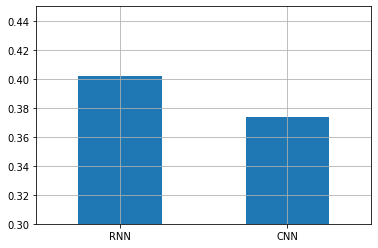

In [ ]:
res[['model', 'accuracy']].plot.bar(x='model', rot=0, legend=False, ylim=[0.3, 0.45], xlabel='', grid=True)